#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model

#### Load Dataset

In [4]:
df = pd.read_csv("loan_encoded.csv")

In [5]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

#### Train / Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Feature Scaling

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Build Neural Network

In [8]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(
        64,
        activation="relu",
        kernel_regularizer=l2(0.001)
    ),
    Dropout(0.3),

    Dense(
        32,
        activation="relu",
        kernel_regularizer=l2(0.001)
    ),
    Dropout(0.2),

    Dense(1, activation="sigmoid")
])


#### Compile Model

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Early Stopping

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#### Train Model

In [11]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping],verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4949 - loss: 0.7954 - val_accuracy: 0.6869 - val_loss: 0.7190
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6684 - loss: 0.6900 - val_accuracy: 0.7677 - val_loss: 0.6607
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7347 - loss: 0.6536 - val_accuracy: 0.7677 - val_loss: 0.6344
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7321 - loss: 0.6194 - val_accuracy: 0.7879 - val_loss: 0.6205
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7577 - loss: 0.6118 - val_accuracy: 0.7879 - val_loss: 0.6106
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7602 - loss: 0.5673 - val_accuracy: 0.7879 - val_loss: 0.6037
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7985 - loss: 0.5488 - val_accuracy: 0.7879 - val_loss: 0.5998
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7883 - loss: 0.5640 - val_accuracy: 0.7879

#### Evaluate Model

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 86.18%


#### Predictions

In [13]:
y_pred_prob = model.predict(X_test, verbose=0)

threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

#### Metrics

In [14]:
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.8617886178861789

Confusion Matrix:
 [[22 16]
 [ 1 84]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



#### ROC Curve & AUC

In [15]:
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc:.3f}")

AUC Score: 0.772


#### Training Curves

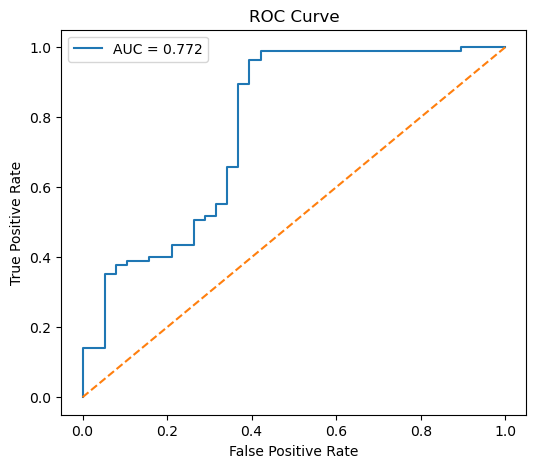

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

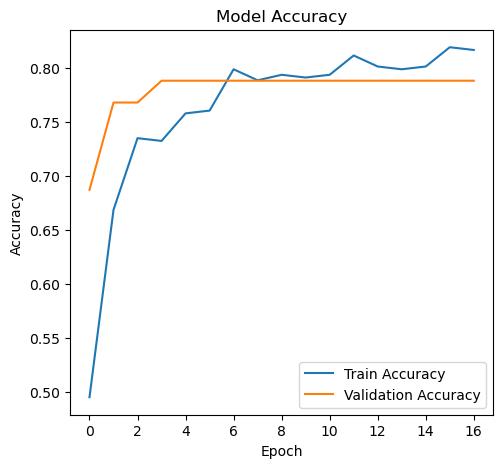

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

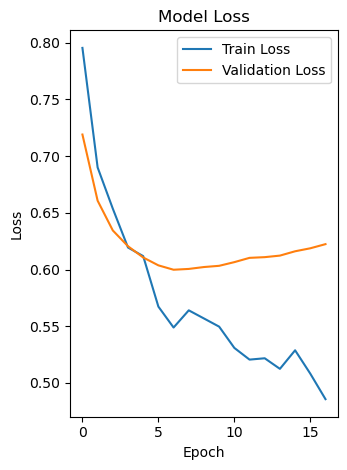

In [18]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.tight_layout()
plt.show()

#### Save Model (Production)

In [21]:
model.save("loan_approval_model.keras")
joblib.dump(scaler, "scaler.pkl")

print("\nModel and scaler saved successfully ✔")


Model and scaler saved successfully ✔


#### Example: New Customer Prediction

In [23]:
feature_names = [
    'Gender_Male',
    'Married_Yes',
    'Dependents',
    'Education_Not Graduate',
    'Self_Employed_Yes',
    'ApplicantIncome',
    'CoapplicantIncome',
    'LoanAmount',
    'Loan_Amount_Term',
    'Credit_History',
    'Property_Area_Semiurban',
    'Property_Area_Urban'
]

new_customer = pd.DataFrame([[ 
    1,      # Gender_Male
    1,      # Married_Yes
    0,      # Dependents
    0,      # Education_Not Graduate (0 = Graduate)
    0,      # Self_Employed_Yes
    5000,   # ApplicantIncome
    200,    # CoapplicantIncome
    360,    # LoanAmount
    360,    # Loan_Amount_Term
    1,      # Credit_History
    0,      # Property_Area_Semiurban
    0       # Property_Area_Urban
]], columns=feature_names)

new_customer = new_customer[X.columns]

new_customer_scaled = scaler.transform(new_customer)

# Prediction
prediction = model.predict(new_customer_scaled)
threshold = 0.5

print("Loan Approved ✅" if prediction >= threshold else "Loan Rejected ❌")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Loan Approved ✅
